<a href="https://colab.research.google.com/github/Spin-Chemistry-Labs/radicalpy/blob/187-google-colab-tutorials/examples/tutorials/04_density_matrices_and_time_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tutorial 4 - Density matrices and time evolution



&copy; Lewis M. Antill, 2025

This tutorial aims to...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import radicalpy as rp
from radicalpy.classical import latexify, latex_eqlist_to_align, Rate, RateEquations
from radicalpy.data import Triplet
from radicalpy.experiments import magnetic_field_loop, kine_quantum_mary, steady_state_mary
from radicalpy.kinetics import Haberkorn, HaberkornFree
from radicalpy.plot import plot_general
from radicalpy.relaxation import RandomFields, SingletTripletDephasing
from radicalpy.simulation import Basis, Molecule, HilbertSimulation, LiouvilleSimulation, SemiclassicalSimulation, State
from radicalpy.utils import Bhalf_fit

In [2]:
# construct the radical pair
radical_1 = Molecule.fromisotopes(name="radical 1", isotopes=["1H", "15N"], hfcs=[])
radical_2 = Molecule.fromisotopes(name="radical 2", isotopes=["13C"], hfcs=[])
sim = HilbertSimulation([radical_1, radical_2])
print (sim)

Number of electrons: 2
Number of nuclei: 0
Number of particles: 2
Multiplicities: [2, 2]
Magnetogyric ratios (mT): [-176085963.023, -176085963.023]
Nuclei: []
Couplings: []
HFCs (mT): []


In [16]:
Bs = np.arange(0, 30, 1)
# J = np.sum((sim.projection_operator(state=State.SINGLET) - sim.projection_operator(state=State.TRIPLET)))
J = 0
D = 0

H = sim.total_hamiltonian(B0=0, D=D, J=J)
init_state = State.SINGLET
time = np.arange(0, 1e-6, 10e-9)
theta = None
phi = None
rhos = magnetic_field_loop(sim=sim, init_state=init_state, time=time, H_base=H, B=Bs, B_axis="z", theta=theta, phi=phi)

  0%|          | 0/30 [00:00<?, ?it/s]c:\Users\lewis\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|██████████| 30/30 [00:00<00:00, 37.58it/s]


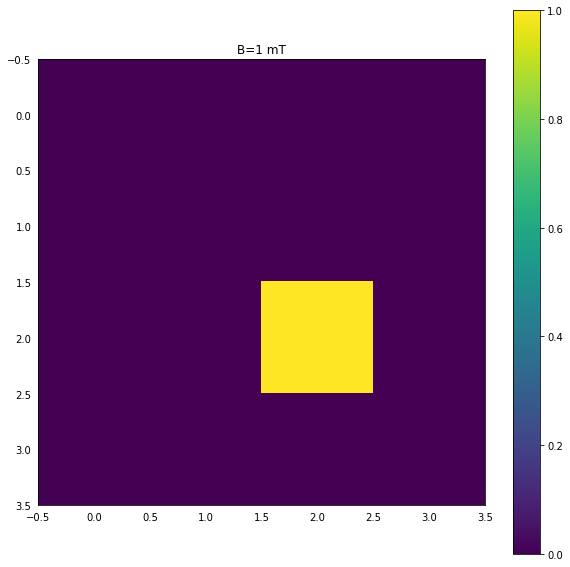

In [21]:
Bi = 1
ti = 10
B = Bs[Bi]
fig = plt.figure()
plt.imshow(np.abs(rhos[Bi, ti]))
plt.title(f"B={B} mT")
plt.tick_params(bottom=False, left=False)
plt.colorbar()
fig.set_size_inches([10, 10])